In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)


In [3]:
from src.activation_functions import *
from src.loss_functions import *
from src.random_search import *
from src.batch_normalization import *
from src.layer import *
from src.early_stopping import *
from src.utils import *
from src.optimizers import *
import itertools
import pandas as pd
import numpy as np
import sys
import os


In [4]:
df_path = "../ML_project/data/cup/ML-CUP24-TR.csv"
df_path2 = "../ML_project/data/cup/ML-CUP24-TS.csv"

# Preview the dataset
df = pd.read_csv(df_path, skiprows=7, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.946373,0.307995,0.820058,-0.309386,0.950936,-0.000913,-0.093048,-0.029318,0.995230,-1.175176,2.295016,0.223732,-0.011599,-0.503652,-5.564158
1,2,-0.074075,-0.992654,-1.162582,0.997240,-0.074209,-0.002159,-0.004956,-0.095561,0.995411,0.675930,3.147029,-0.297508,-0.361982,-0.186246,3.445744
2,3,0.841384,0.531605,0.810176,-0.534053,0.845451,-0.001057,-0.082832,-0.051079,0.995254,-1.069958,2.415989,0.234664,0.170027,-0.344143,-3.675575
3,4,0.737117,-0.668400,-1.065601,0.671734,0.740793,0.000008,0.073704,-0.066844,0.995038,11.038418,1.003455,-0.100332,-1.032355,-1.184874,15.554511
4,5,-0.987858,-0.119426,-1.072857,0.120013,-0.992772,0.000064,-0.098661,-0.011863,0.995050,14.834930,1.127759,-0.112600,-0.134817,2.047468,20.522760


In [5]:
df.columns = ["ID"] + [f'input_{i}' for i in range(12)] + ['target_x', 'target_y', 'target_z']
df = df.drop("ID", axis=1)

In [6]:
X_train, X_val, y_train, y_val, X_scaler, y_scaler = preprocess_data(
    df, 
    target=["target_x", "target_y", "target_z"],
    normalize_type="z-score",
    val_ratio=0.2,
    regression=True
)

           0         1          2
0  -0.421997  0.236717  -7.342594
1  -0.283333  0.050838   3.428940
2   0.137419  0.030498  -2.907336
3   1.758643 -0.886580  16.933458
4  -1.091619  0.158737   2.392301
5  -0.030139 -0.041892  -0.703612
6  -0.537285  0.111040   2.657905
7  -0.296103  0.080915   2.885263
8  -1.578751 -0.185479  14.876680
9   1.155768 -0.025354  12.329478
10  0.237865  0.755455   7.693303
11  0.880421  0.209778  -8.828166
12  0.687578  0.985988  14.896379
13  0.762072  0.217130  -9.108539
14 -2.156456 -0.696712  20.812513
15 -0.494655  0.115973  -5.513408
16 -1.620315 -0.362419  17.202943
17  0.149752  0.676320   8.854500
18 -0.794149 -1.553299  17.377104
19 -0.049514  0.745878   8.182392
20  2.333131 -0.558883  24.923707
21  1.227097  0.381899  14.242438
22 -0.740300  0.539295   8.972121
23 -1.312315 -1.067413  16.626081
24  0.588437  0.455289  -9.114358
25 -1.013359 -0.028985   8.870993
26  1.082475 -1.512010  18.644240
27  0.109942  0.027452  -2.324193
28  0.602006  

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((200, 12), (200, 3), (50, 12), (50, 3))

In [8]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [ ]:
param_distributions = {
    'hidden_size': [10],
    'n_h_layers': [2],
    'hidden_activation': [Activation_Tanh],
    'batch_norm': [True],
    'learning_rate': [9e-3],  #np.logspace(-3, -1, num=5).tolist(),
    'l1': [1e-9], #np.logspace(-7, -5, num=5).tolist(),
    'l2': [1e-6], #np.logspace(-7, -2, num=5).tolist(),
    'dropout_rate': [0], #np.logspace(-4, -2, num=5).tolist(),
    'batch_size': [64],
    'n_epochs': [350],
    'weight_decay': [1e-7], #np.logspace(-4, -1, num=5).tolist(),
    'patience': [30],
    'CC': [False],
    'weights_init': ['gaussian_scaled'],
    'output_activation': [Activation_Linear()],
    'sched_decay': [1.4]
}

print(f"Number of possible combinations: {count_permutations(param_distributions)}")

Number of possible combinations: 1


In [36]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,
                                                   param_distributions=param_distributions,
                                                   n_iters=count_permutations(param_distributions), regression=True, csv_path="cup_top5res.csv")  # adjust n_iters as needed


Iteration 0
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
✅ Fold 1/5 | Validation Accuracy: 0.8883
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
✅ Fold 2/5 

In [37]:
print(best_hyperparams)

{'hidden_size': 10, 'n_h_layers': 2, 'hidden_activation': <class 'src.activation_functions.Activation_Tanh'>, 'batch_norm': True, 'learning_rate': 0.009, 'l1': 1e-09, 'l2': 1e-06, 'dropout_rate': 0, 'batch_size': 64, 'n_epochs': 350, 'weight_decay': 1e-07, 'patience': 30, 'CC': False, 'weights_init': 'gaussian_scaled', 'output_activation': <src.activation_functions.Activation_Linear object at 0x7f33b2bbfce0>, 'val_accuracy': np.float64(0.9095839404366289)}


Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Diminish lr
Final Validation R² Score: 0.9157; Loss 0.0860


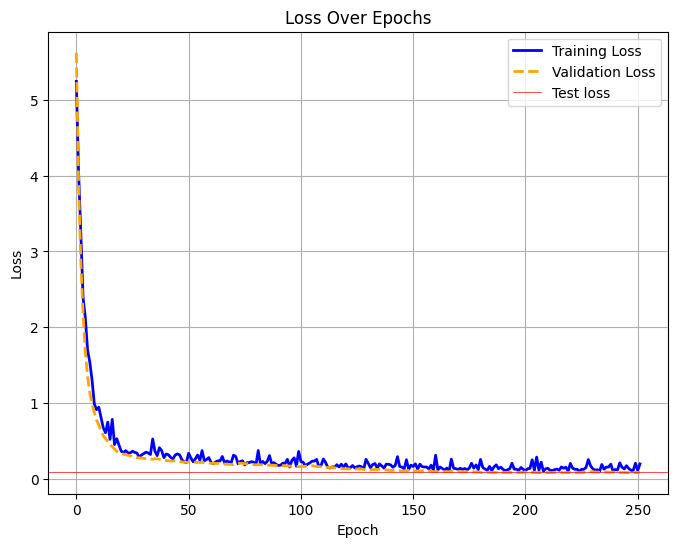

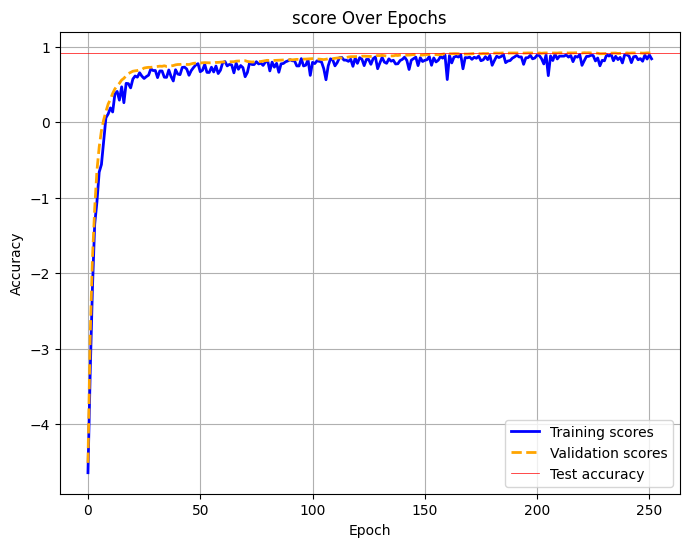

In [39]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 12, output_size=3, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=12,
        hidden_size=best_hyperparams['hidden_size'],
        output_size=3,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rate=best_hyperparams['dropout_rate'],
        use_batch_norm=best_hyperparams['batch_norm'],
        n_h_layers=best_hyperparams['n_h_layers'],
        output_activation=best_hyperparams['output_activation']
    )

train = Train(best_hyperparams, model, regression=True)
train.train_and_evaluate(X_train, y_train, X_val, y_val)
train.test(X_val, y_val)
print(f"Final Validation R² Score: {train.test_score:.4f}; Loss {train.test_loss:.4f}")
train.plot(score=True)